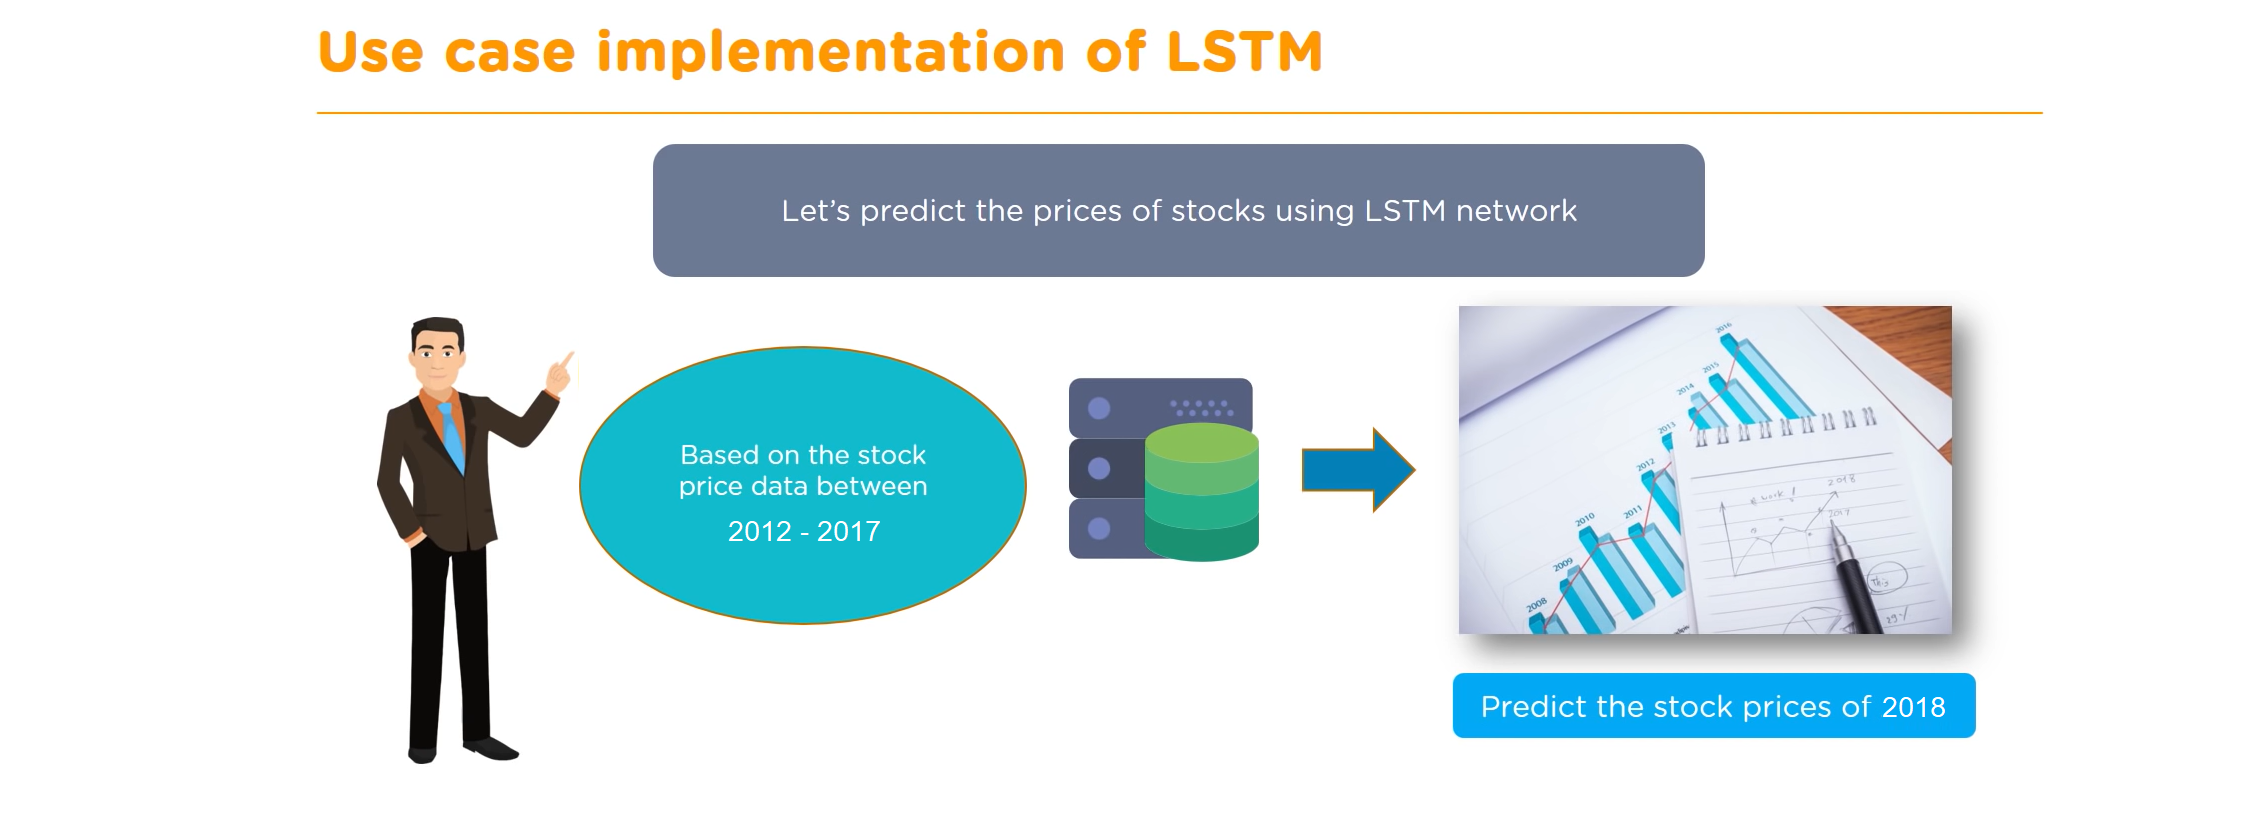

### 1. Problem statement
__LSTM for Stock Price Prediction__

Technical Walk-through on LSTM-based Recurrent Neural Network Creation for Google Stock Price Prediction

- We are given Google stock price from 01/2012 to 12/2017. 
- The task is to predict the trend of the stock price for 01-06 2018.

### 2. Import library

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

### 3. Data processing

#### 3.0 import the data

In [86]:
dataset_train = pd.read_csv('.\Dataset\Google_Stock_Price_Train.csv')

In [87]:
print (dataset_train.shape)
dataset_train

(1509, 6)


,Date,Open,High,Low,Close,Volume
0,01/03/2012,325.250000,332.830000,324.970000,663.59,"7,380,500"
1,01/04/2012,331.270000,333.870000,329.080000,666.45,"5,749,400"
2,01/05/2012,329.830000,330.750000,326.890000,657.21,"6,590,300"
3,01/06/2012,328.340000,328.770000,323.680000,648.24,"5,405,900"
4,01/09/2012,322.040000,322.290000,309.460000,620.76,"11,688,800"
...,...,...,...,...,...,...
1504,22/12/2017,1061.109985,1064.199951,1059.439941,1060.119995,755100
1505,26/12/2017,1058.069946,1060.119995,1050.199951,1056.73999,760600
1506,27/12/2017,1057.390015,1058.369995,1048.050049,1049.369995,1271900
1507,28/12/2017,1051.599976,1054.750000,1044.770020,1048.140015,837100


In [116]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1509 non-null   object 
 1   Open    1509 non-null   float64
 2   High    1509 non-null   float64
 3   Low     1509 non-null   float64
 4   Close   1509 non-null   object 
 5   Volume  1509 non-null   object 
dtypes: float64(3), object(3)
memory usage: 70.9+ KB


From here we can see our data has 6 columns:
* **Date**: The date of recorded data
* **Open**: The price when stock market open on that date
* **High**: The highest price on that date
* **Low**: The lowest price point on that date
* **Close**: The closet price point on that date
* **Volumn**: Total Sale of stock on that date

In [88]:
# keras only takes numpy array
training_set = dataset_train.iloc[:, 1: 2].values

In [89]:
print (training_set.shape)
training_set

(1509, 1)


array([[ 325.25    ],
       [ 331.27    ],
       [ 329.83    ],
       ...,
       [1057.390015],
       [1051.599976],
       [1046.719971]])

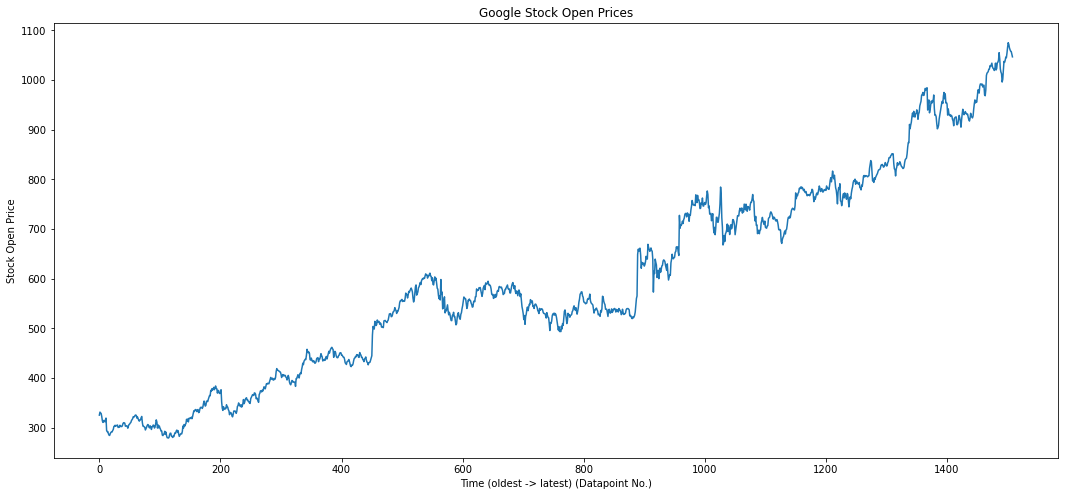

In [90]:
plt.figure(figsize=(18, 8))
plt.plot(dataset_train['Open'])
plt.title("Google Stock Open Prices")
plt.xlabel("Time (oldest -> latest) (Datapoint No.)")
plt.ylabel("Stock Open Price")
plt.show()

#### 3.1 Feature scaling

The next step is to scale the stock prices between (0, 1) to avoid intensive computation. Common methods include **Standardization** and **Normalization**. It is recommended to take Normalization, particularly when working on RNN with a Sigmoid function in the output layer.

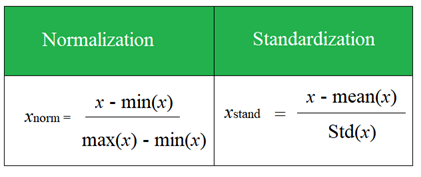

In [91]:
sc = MinMaxScaler(feature_range = (0, 1))
# fit: get min/max of train data
training_set_scaled = sc.fit_transform(training_set)

In [92]:
print (np.argmax(training_set), training_set[np.argmax(training_set)], training_set_scaled[np.argmax(training_set)])
print (np.argmin(training_set), training_set[np.argmin(training_set)], training_set_scaled[np.argmin(training_set)])
print (training_set_scaled.shape)
training_set_scaled

1501 [1075.199951] [1.]
114 [279.12] [0.]
(1509, 1)


array([[0.05794644],
       [0.0655085 ],
       [0.06369963],
       ...,
       [0.97762796],
       [0.97035477],
       [0.96422472]])

#### 3.2 Data Structure creation
__Creating a sliding window is important!__

A special data structure is needed to cover 60-time stamps, based on which RNN will predict the 61st price. Here the number of past timestamps is set to 60 based on experimentation. Thus, X_train is a nested list, which contains lists of 60 time-stamp prices. y_train is a list of stock prices which is the next day stock price, corresponding to each list in X_train. Specifically,

- taking the reference of past 60 days of data to predict the future stock price.  
- It is observed that taking 60 days of past data gives us best results.  
- In this data set 60 days of data means 3 months of data.  
- Every month as 20 days of Stock price.   
- X train will have data of 60 days prior to our date and y train will have data of one day after our date

In [93]:
## 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60: i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [94]:
print (X_train.shape)
X_train

(1449, 60)


array([[0.05794644, 0.0655085 , 0.06369963, ..., 0.05298463, 0.05425334,
        0.05738117],
       [0.0655085 , 0.06369963, 0.06182796, ..., 0.05425334, 0.05738117,
        0.05826048],
       [0.06369963, 0.06182796, 0.05391418, ..., 0.05738117, 0.05826048,
        0.05720531],
       ...,
       [0.85526583, 0.84775405, 0.85152251, ..., 0.98712441, 0.98230082,
        0.97848205],
       [0.84775405, 0.85152251, 0.84962571, ..., 0.98230082, 0.97848205,
        0.97762796],
       [0.85152251, 0.84962571, 0.86370723, ..., 0.97848205, 0.97762796,
        0.97035477]])

In [95]:
print (y_train.shape)
y_train

(1449,)


array([0.05826048, 0.05720531, 0.05033414, ..., 0.97762796, 0.97035477,
       0.96422472])

#### 3.3 Data reshaping

In [96]:
X_train = np.reshape(X_train, newshape = 
                     (X_train.shape[0], X_train.shape[1], 1))
print (X_train.shape)
X_train

(1449, 60, 1)


array([[[0.05794644],
        [0.0655085 ],
        [0.06369963],
        ...,
        [0.05298463],
        [0.05425334],
        [0.05738117]],

       [[0.0655085 ],
        [0.06369963],
        [0.06182796],
        ...,
        [0.05425334],
        [0.05738117],
        [0.05826048]],

       [[0.06369963],
        [0.06182796],
        [0.05391418],
        ...,
        [0.05738117],
        [0.05826048],
        [0.05720531]],

       ...,

       [[0.85526583],
        [0.84775405],
        [0.85152251],
        ...,
        [0.98712441],
        [0.98230082],
        [0.97848205]],

       [[0.84775405],
        [0.85152251],
        [0.84962571],
        ...,
        [0.98230082],
        [0.97848205],
        [0.97762796]],

       [[0.85152251],
        [0.84962571],
        [0.86370723],
        ...,
        [0.97848205],
        [0.97762796],
        [0.97035477]]])

In [97]:
X_train.shape

(1449, 60, 1)

In [98]:
print ("1. Number of stock prices -", X_train.shape[0])
print ("2. Number of time steps -", X_train.shape[1])
print ("3. Number of Indicator -", X_train.shape[2])

1. Number of stock prices - 1449
2. Number of time steps - 60
3. Number of Indicator - 1


### 4. Create & Fit Model

#### 4.1 Create model

In [99]:
regressor = Sequential()
## add 1st lSTM layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))

## add 2nd lSTM layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

## add 3rd lSTM layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

## add 4th lSTM layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

## add output layer: 1 neuron
regressor.add(Dense(units = 1))

In [100]:
# For optimizer, we use Adam, a safe choice to start with. The loss function is the mean of squared errors (MSE)
# between actual values and predictions.
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

#### 4.2 Model fit

In [101]:
# RNN weights are updated every 32 stock prices with a batch size of 32.
regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)

Epoch 1/100
46/46 [==============================] - 24s 195ms/step - loss: 0.0210
Epoch 2/100
46/46 [==============================] - 9s 196ms/step - loss: 0.0039
Epoch 3/100
46/46 [==============================] - 9s 200ms/step - loss: 0.0034
Epoch 4/100
46/46 [==============================] - 9s 194ms/step - loss: 0.0032
Epoch 5/100
46/46 [==============================] - 9s 202ms/step - loss: 0.0030
Epoch 6/100
46/46 [==============================] - 9s 194ms/step - loss: 0.0029
Epoch 7/100
46/46 [==============================] - 9s 189ms/step - loss: 0.0027
Epoch 8/100
46/46 [==============================] - 8s 181ms/step - loss: 0.0033
Epoch 9/100
46/46 [==============================] - 9s 191ms/step - loss: 0.0030
Epoch 10/100
46/46 [==============================] - 8s 184ms/step - loss: 0.0027
Epoch 11/100
46/46 [==============================] - 9s 202ms/step - loss: 0.0023
Epoch 12/100
46/46 [==============================] - 8s 175ms/step - loss: 0.0024
Epoch 13/100

#### 4.3 Model evaluation

#### 4.3.1 Read and convert

In [102]:
# reading test data
dataset_test = pd.read_csv('.\Dataset\Google_Stock_Price_Test.csv')

In [103]:
print (dataset_test.shape)
dataset_test

(125, 6)


,Date,Open,High,Low,Close,Volume
0,02/01/2018,1048.339966,1066.939941,1045.229980,1065.000000,1237600
1,03/01/2018,1064.310059,1086.290039,1063.209961,1082.479980,1430200
2,04/01/2018,1088.000000,1093.569946,1084.001953,1086.400024,1004600
3,05/01/2018,1094.000000,1104.250000,1092.000000,1102.229980,1279100
4,08/01/2018,1102.229980,1111.270020,1101.619995,1106.939941,1047600
...,...,...,...,...,...,...
120,25/06/2018,1143.599976,1143.910034,1112.780029,1124.810059,2157300
121,26/06/2018,1128.000000,1133.209961,1116.659058,1118.459961,1563200
122,27/06/2018,1121.339966,1131.836060,1103.619995,1103.979980,1293900
123,28/06/2018,1102.089966,1122.310059,1096.010010,1114.219971,1072400


In [117]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    125 non-null    object 
 1   Open    125 non-null    float64
 2   High    125 non-null    float64
 3   Low     125 non-null    float64
 4   Close   125 non-null    float64
 5   Volume  125 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 6.0+ KB


From here we can see our data has 6 columns:
* **Date**: The date of recorded data
* **Open**: The price when stock market open on that date
* **High**: The highest price on that date
* **Low**: The lowest price point on that date
* **Close**: The closet price point on that date
* **Volumn**: Total Sale of stock on that date

In [104]:
# keras only takes numpy array
real_stock_price = dataset_test.iloc[:, 1: 2].values
print (real_stock_price.shape)
real_stock_price

(125, 1)


array([[1048.339966],
       [1064.310059],
       [1088.      ],
       [1094.      ],
       [1102.22998 ],
       [1109.400024],
       [1097.099976],
       [1106.300049],
       [1102.410034],
       [1132.51001 ],
       [1126.219971],
       [1131.410034],
       [1131.829956],
       [1137.48999 ],
       [1159.849976],
       [1177.329956],
       [1172.530029],
       [1175.079956],
       [1176.47998 ],
       [1167.829956],
       [1170.569946],
       [1162.609985],
       [1122.      ],
       [1090.599976],
       [1027.180054],
       [1081.540039],
       [1055.410034],
       [1017.25    ],
       [1048.      ],
       [1045.      ],
       [1048.949951],
       [1079.069946],
       [1088.410034],
       [1090.569946],
       [1106.469971],
       [1116.189941],
       [1112.640015],
       [1127.800049],
       [1141.23999 ],
       [1123.030029],
       [1107.869995],
       [1053.079956],
       [1075.140015],
       [1099.219971],
       [1089.189941],
       [11

#### 4.3.2 Concat and convert

First, we need to concatenate the train and test datasets for prediction, because we use the previous 60 days’ stock prices to predict the next-day price. In another word, we need the 60 days’ price before the 1st date in the test dataset.

In [105]:
# vertical concat use 0, horizontal uses 1
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), 
                          axis = 0)
print (dataset_total.shape, type(dataset_total))  # 1509 + 125
dataset_total

(1634,) <class 'pandas.core.series.Series'>


0       325.250000
1       331.270000
2       329.830000
3       328.340000
4       322.040000
          ...     
120    1143.599976
121    1128.000000
122    1121.339966
123    1102.089966
124    1120.000000
Name: Open, Length: 1634, dtype: float64

In [106]:
## use .values to make numpy array
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values  # slicing values starting from index
                                                                             # 1634 - 125 - 60 = 1449 onwards
print (inputs.shape, type(inputs))
inputs

(185,) <class 'numpy.ndarray'>


array([ 955.48999 ,  966.700012,  980.      ,  980.      ,  973.719971,
        987.450012,  992.      ,  992.099976,  990.289978,  991.77002 ,
        986.      ,  989.440002,  989.52002 ,  970.      ,  968.369995,
        980.      , 1009.190002, 1014.      , 1015.219971, 1017.210022,
       1021.76001 , 1022.109985, 1028.98999 , 1027.27002 , 1030.52002 ,
       1033.98999 , 1026.459961, 1023.419983, 1022.590027, 1019.210022,
       1022.52002 , 1034.01001 , 1020.26001 , 1023.309998, 1035.      ,
       1035.869995, 1040.      , 1055.089966, 1042.680054, 1022.369995,
       1015.799988, 1012.659973,  995.940002, 1001.5     , 1020.429993,
       1037.48999 , 1035.5     , 1039.630005, 1046.119995, 1045.      ,
       1054.609985, 1066.079956, 1075.199951, 1071.780029, 1064.949951,
       1061.109985, 1058.069946, 1057.390015, 1051.599976, 1046.719971,
       1048.339966, 1064.310059, 1088.      , 1094.      , 1102.22998 ,
       1109.400024, 1097.099976, 1106.300049, 1102.410034, 1132.

In [107]:
print (len(dataset_total), len(dataset_test), len(dataset_total) - len(dataset_test) - 60)

1634 125 1449


#### 4.3.3 Reshape and scale

In [108]:
# reshape data to only have 1 col
inputs = inputs.reshape(-1, 1)
print (inputs.shape, type(inputs))
inputs

(185, 1) <class 'numpy.ndarray'>


array([[ 955.48999 ],
       [ 966.700012],
       [ 980.      ],
       [ 980.      ],
       [ 973.719971],
       [ 987.450012],
       [ 992.      ],
       [ 992.099976],
       [ 990.289978],
       [ 991.77002 ],
       [ 986.      ],
       [ 989.440002],
       [ 989.52002 ],
       [ 970.      ],
       [ 968.369995],
       [ 980.      ],
       [1009.190002],
       [1014.      ],
       [1015.219971],
       [1017.210022],
       [1021.76001 ],
       [1022.109985],
       [1028.98999 ],
       [1027.27002 ],
       [1030.52002 ],
       [1033.98999 ],
       [1026.459961],
       [1023.419983],
       [1022.590027],
       [1019.210022],
       [1022.52002 ],
       [1034.01001 ],
       [1020.26001 ],
       [1023.309998],
       [1035.      ],
       [1035.869995],
       [1040.      ],
       [1055.089966],
       [1042.680054],
       [1022.369995],
       [1015.799988],
       [1012.659973],
       [ 995.940002],
       [1001.5     ],
       [1020.429993],
       [10

In [109]:
# scale input
inputs = sc.transform(inputs)

In [110]:
print (len(inputs))
inputs

185


array([[0.84962571],
       [0.86370723],
       [0.88041408],
       [0.88041408],
       [0.87252539],
       [0.88977245],
       [0.89548795],
       [0.89561353],
       [0.89333989],
       [0.89519906],
       [0.88795101],
       [0.89227219],
       [0.89237271],
       [0.86785253],
       [0.86580499],
       [0.88041408],
       [0.91708126],
       [0.92312336],
       [0.92465583],
       [0.92715565],
       [0.93287114],
       [0.93331076],
       [0.94195312],
       [0.93979257],
       [0.94387507],
       [0.94823389],
       [0.93877501],
       [0.93495632],
       [0.93391377],
       [0.92966796],
       [0.93382583],
       [0.94825904],
       [0.93098691],
       [0.93481816],
       [0.94950262],
       [0.95059547],
       [0.9557834 ],
       [0.97473874],
       [0.95914996],
       [0.93363737],
       [0.92538443],
       [0.92144008],
       [0.9004372 ],
       [0.90742142],
       [0.93120043],
       [0.95263043],
       [0.9501307 ],
       [0.955

#### 4.3.4 Create test data strucutre

In [111]:
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
# add dimension of indicator
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [112]:
print (X_test.shape)
X_test

(125, 60, 1)


array([[[0.84962571],
        [0.86370723],
        [0.88041408],
        ...,
        [0.97762796],
        [0.97035477],
        [0.96422472]],

       [[0.86370723],
        [0.88041408],
        [0.88041408],
        ...,
        [0.97035477],
        [0.96422472],
        [0.96625969]],

       [[0.88041408],
        [0.88041408],
        [0.87252539],
        ...,
        [0.96422472],
        [0.96625969],
        [0.98632061]],

       ...,

       [[0.92301027],
        [0.89725909],
        [0.95745403],
        ...,
        [1.10544175],
        [1.08592105],
        [1.06632506]],

       [[0.89725909],
        [0.95745403],
        [0.93066029],
        ...,
        [1.08592105],
        [1.06632506],
        [1.05795902]],

       [[0.95745403],
        [0.93066029],
        [0.92664058],
        ...,
        [1.06632506],
        [1.05795902],
        [1.03377803]]])

#### 4.3.5 Model prediction

In [113]:
predicted_stock_price = regressor.predict(X_test)

In [114]:
# inverse the scaled value
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print (predicted_stock_price.shape, type (predicted_stock_price))

(125, 1) <class 'numpy.ndarray'>


#### 4.3.6 Result visualization

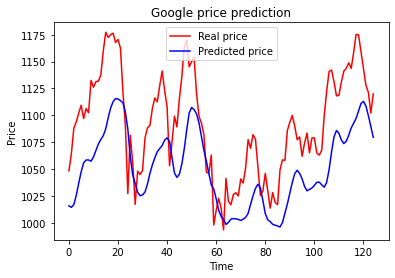

In [115]:
##visualize the prediction and real price
plt.plot(real_stock_price, color = 'red', label = 'Real price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')

plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()